In [1]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt

from itertools import islice
from scipy.linalg import block_diag
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

In [2]:
# Create a new document term matrix using the topic distribution
def create_matrix(windows_H, windows_terms):
    """
    Create the topic-term matrix from all window topics that have been added so far.
    Parameters:
    ----------
    windows_H: windiws topic distribution of top n words
    windows_terms: windows terms used for each fiscal year
    """
    # Set a list of all terms unique terms across windows (all_terms) and the combine windows terms (all_windows_terms)
    all_windows_terms = sum(windows_terms,[])
    
    # Create a block diagonal matrix of all topics: the number of rows is the same as the length of list_terms
    M = block_diag(*windows_H)
    
    # Identify duplicated terms (columns) and sum them
    # The fastest way is to transform M into data frame with
    dfM = pd.DataFrame(data = M, columns=all_windows_terms).groupby(level=0, axis=1).sum()
    
    # Transform back the dataframe to matrix and get the variable names (in the order in the matrix) as the final all terms
    M_concat = dfM.to_numpy()
    all_terms = list(dfM.columns)
    
    
    print('--- New document-terms have been created ---')
    
    return M_concat, all_terms



# Track the dynamic of a given topic (option topic)
def track_dynamic(topic,W,windows_topic_list):
    """
    Link topics in the first stage with topic in second stage using the matrix W
    Parameters:
    ----------
    topic: topic to track the dynamic
    W: weigth matrix from the second stage
    windows_topic_list: topic list from the first stage
    """
    # For each topic from the first stage (rows) find the topic in the second stage (columns) with the higher weight
    topic_second = []
    for i, topic_first in enumerate(W):
        topic_second.append(topic_first.argmax())
        
    # Split topics classification in the first by year
    it = iter(topic_second)
    topic_first_year = [[next(it) for _ in range(size)] for size in windows_topic]
    
    # For each topic, identify the correspondance for each year
    dynamic_topic_list = []
    for y in range(0, len(year)):
        topic_year = [i for i, e in enumerate(topic_first_year[y]) if e == topic]
        dynamic_topic_list.append(topic_year)

    # Compute the list of list of topics (list of year and list of main topic)
    dynamic_topic = []
    for y in range(0, len(year)):
        dynamic_list = dynamic_topic_list[y]
        fy_topic = [windows_topic_list[y][dynamic_list[i]] for i in range(0,len(dynamic_list))] 
        dynamic_topic.append(fy_topic)
        
    # Print the result in a dataframe
    topic_print = []
    names = []

    # print the dynamic topic
    for y in range(0,len(year)):
        for t in range(0,len(dynamic_topic[y])):
            topic_print.append(dynamic_topic[y][t])
            names.append('Year_'+str(year[y])+'_'+str(t))
        
    df = pd.DataFrame (topic_print).transpose()
    df.columns = names
    
    return df, dynamic_topic_list

# set all functions
# function to list topic (modified function from https://nlpforhackers.io/topic-modeling/)
def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.  
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1: 
            # check if the vectorized has an attribute get_features_names. if not vectorized contains terms hasattr('abc', 'lower')
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[::-1]])
        else:
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words


# function to solve the nmf (modified from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)
def nmf_models(doc_term_matrix, n_topics, vectorizer, rand_start):
    """
    Compute NMF model, save topics list for coherence calc
    Parameters:
    ----------
    doc_term_matrix: document-terms matrix
    n_topics: list of topics number
    vectorizer: vector of terms
    rand_start: random seed
    """
    
    nmf_time = []
    topics_list = []
    W_list = []
    H_list = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        nmf_time.append(t2-t1)
        #print(f"  Model time: {t2-t1}", flush=True)
        
        # create list of topics
        topics = list_topics(nmf_model.components_, vectorizer, top_n=10)
        topics_list.append(topics)
        
        # output completion message
        i = i+1
        #print('Number of topics =', num_topics, "complete.", flush=True)
        
        # save the matrix W and H
        W = nmf_model.fit_transform(doc_term_matrix)
        W_list.append(W)
        H = nmf_model.components_
        
        # truncate the H matrix: set the weight of the non top n words to zero
        #top_n = 10
        #for idx, topic in enumerate(H):
        #    thresold = numpy.nanmin(topic[topic.argsort()[:-top_n-1:-1]])
        #    topic[topic<thresold]=0  
        H_list.append(H)

    return nmf_time, topics_list, W_list, H_list

# solve an nmf model for each windows topic
def track_dynamic(topic,W,windows_topic_list,windows_topic):
    """
    Link topics in the first stage with topic in second stage using the matrix W
    Parameters:
    ----------

    """
    # For each topic from the first stage (rows) find the topic in the second stage (columns) with the higher weight
    topic_second = []
    for i, topic_first in enumerate(W):
        topic_second.append(topic_first.argmax())
        
    # Split topics classification in the first by year
    it = iter(topic_second)
    topic_first_year = [[next(it) for _ in range(size)] for size in windows_topic]
    
    # For each topic, identify the correspondance for each year
    dynamic_topic_list = []
    for y in range(0, len(year)):
        topic_year = [i for i, e in enumerate(topic_first_year[y]) if e == topic]
        dynamic_topic_list.append(topic_year)

    # Compute the list of list of topics (list of year and list of main topic)
    dynamic_topic = []
    for y in range(0, len(year)):
        dynamic_list = dynamic_topic_list[y]
        fy_topic = [windows_topic_list[y][dynamic_list[i]] for i in range(0,len(dynamic_list))] 
        dynamic_topic.append(fy_topic)
        
    # Print the result in a dataframe
    topic_print = []
    names = []

    # print the dynamic topic
    for y in range(0,len(year)):
        for t in range(0,len(dynamic_topic[y])):
            topic_print.append(dynamic_topic[y][t])
            names.append('Year_'+str(year[y])+'_'+str(t))
        
    df = pd.DataFrame (topic_print).transpose()
    df.columns = names
    
    return df, dynamic_topic_list


In [3]:
# Load the dataset.
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.head()

# Compute the time variable
year = df['FY'].unique()
del df

path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/'
n_topics = list(range(20,61,5))

In [4]:
# Create a new term-document matrix: Combining all the top term from the windows nmf
windows_topic_list = []
windows_W = []
windows_H = []
windows_terms = []

# Build the windows H matrix
  
for fy in year:
    # Upload the nmf model 
    tfidf_vectorizer = joblib.load( path+'Term_docs_'+str(fy)+'.pkl' )[1]
    (nmf_time,topics_list,W_list,H_list) = joblib.load( path+'nmf_out/windows_nmf'+str(fy)+'.pkl' )
    (model, max_coherence) = joblib.load( path+'Coherence/model_'+str(fy)+'.pkl' )
    
    # Build the list of terms for all topics (top_n) in a given fiscal year
    fy_topic_list = topics_list[model]
    
    # Get the H and W matrix for the model
    W = W_list[model]
    H = H_list[model]
    
    # select the index of terms that appear in the topics and subset the matrix H to those terms
    if hasattr(tfidf_vectorizer, 'get_feature_names'):
        terms = tfidf_vectorizer.get_feature_names()
    else:
        terms = tfidf_vectorizer
        
    # select the index of terms that appear in the topics and subset the matrix H to those terms
    topic_terms = list(set(sum(fy_topic_list,[])))
    indcol = [terms.index(i) for i in topic_terms]
    subH = H[:,indcol]
        
    # For each topic (rows) set the weigth of terms that are not listed the topic to 0.
    for i,j in enumerate(subH):
        # by row find the index of top_n terms
        indtopic = [topic_terms.index(p) for p in fy_topic_list[i]]
        notop = [k for k in range(len(topic_terms)) if k not in indtopic]
        j[notop]=0

    # append the result
    windows_topic_list.append(fy_topic_list)
    windows_W.append(W)
    windows_H.append(subH)
    windows_terms.append(topic_terms)
    

In [5]:
# Build the new document-term matrix M
(M, all_terms) = create_matrix(windows_H, windows_terms)
 
# save the new tif-idf matrix
joblib.dump((M, all_terms), path+'new_Term_docs.pkl' )

--- New document-terms have been created ---


['/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/new_Term_docs.pkl']

In [6]:
# Run am nmf model from the new document term matrix
batch = 7
(nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=M, n_topics=n_topics, vectorizer=all_terms, rand_start = (batch)*len(n_topics))

# Save the result for the second nmf
joblib.dump((nmf_time,topics_list,W_list,H_list), path+'nmf_out/second_stage.pkl' )

['/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/nmf_out/second_stage.pkl']

## Comment: Run this section if not using slurm

In [ ]:
# Compute the coherence for the dynamic
coherence = []

# upload the result that are necessary for the coherence
topics_list = joblib.load( path+'nmf_out/second_stage.pkl' )[1]
(docs,dictionary) = joblib.load( path+'dico_docs.pkl' )
    
for t in range(0,len(n_topics)):
    term_rankings = topics_list[t]
    cm = CoherenceModel(topics=term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=1)
        
    # get the coherence value
    coherence.append(cm.get_coherence())
    print("one step")
    
# find the topics that maximize the coherence
max_value = numpy.nanmax(coherence)
index = coherence.index(max_value)

print('------- solve coherence for a year -------')
    
# Save the result from the first step
joblib.dump((index, max_value, coherence), path+'Coherence/final_model.pkl' )

one step
one step
one step
one step
one step
one step
one step


## Comment: Run this section if using slurm

In [7]:
# Plot the coherence
(index, max_value, coherence) = joblib.load( path+'Coherence/final_model.pkl' )
(nmf_time,topics_list,W_list,H_list) = joblib.load( path+'nmf_out/second_stage.pkl' )
windows_topic = joblib.load( path+'first_stage.pkl' )[0]

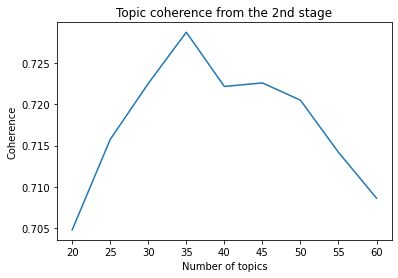

In [8]:
# Plot the coherence
coherence_ts = pd.Series(coherence, index =n_topics)
plt.plot(coherence_ts)
plt.title('Topic coherence from the 2nd stage')
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.savefig( '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Coherence/Coherence_second_stage.png')

In [9]:
# find the best topic at the second stage: topic that maximize the coherence
topic_select = n_topics[index]
topic_list = topics_list[index]
W = W_list[index]
H = H_list[index]
print('The best topic based on coherence is topic: '+str(topic_select))

The best topic based on coherence is topic: 35


In [10]:
# Print the list of topics
for i in range(0,len(topic_list)):
    print(topic_list[i])

['cell', 'type', 'differentiation', 'cd4', 'cellular', 'stem', 'antigen', 'tissue', 'epithelial', 'culture']
['mouse', 'model', 'human', 'animal', 'transgenic', 'mutation', 'vivo', 'mutant', 'disease', 'study']
['child', 'parent', 'family', 'language', 'pediatric', 'childhood', 'early', 'infant', 'school', 'asd']
['patient', 'treatment', 'therapy', 'outcome', 'disease', 'improve', 'biomarker', 'treat', 'symptom', 'study']
['hiv', 'aids', 'infect', 'infection', 'prevention', 'antiretroviral', 'transmission', 'art', 'cfar', 'msm']
['protein', 'membrane', 'structure', 'bind', 'complex', 'interaction', 'function', 'structural', 'domain', 'rna']
['signal', 'pathway', 'regulate', 'mechanism', 'activation', 'role', 'regulation', 'kinase', 'growth', 'receptor']
['health', 'community', 'disparity', 'public', 'population', 'policy', 'minority', 'mental', 'environmental', 'partnership']
['drug', 'compound', 'resistance', 'target', 'inhibitor', 'cocaine', 'abuse', 'treatment', 'therapeutic', 'addi

In [11]:
my_df = pd.DataFrame(topic_list)
my_df.to_csv('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Dynamic_topic_list.csv', index=False, header=False)

In [12]:
# Select a topic and observw the dynamic
topic = 27
(topic_df,assign) = track_dynamic(topic,W,windows_topic_list,windows_topic)
topic_df

,Year_2008_0,Year_2008_1,Year_2009_0,Year_2009_1,Year_2010_0,Year_2010_1,Year_2011_0,Year_2011_1,Year_2012_0,Year_2012_1,...,Year_2018_1,Year_2018_2,Year_2018_3,Year_2019_0,Year_2019_1,Year_2019_2,Year_2019_3,Year_2020_0,Year_2020_1,Year_2020_2
0,training,conference,training,conference,training,conference,training,conference,training,conference,...,conference,program,dr,program,training,dr,conference,training,food,dr
1,program,meeting,program,meeting,program,meeting,program,meeting,program,meeting,...,meeting,member,career,member,trainee,career,meeting,program,laboratory,career
2,trainee,workshop,trainee,workshop,trainee,workshop,trainee,workshop,trainee,workshop,...,2018,funding,mentor,funding,faculty,mentor,2019,trainee,testing,mentor
3,faculty,2008,faculty,international,faculty,2010,faculty,2011,faculty,scientist,...,workshop,scholar,award,department,mentor,award,workshop,faculty,safety,award
4,biology,international,biology,scientist,mentor,researcher,biology,researcher,mentor,science,...,researcher,year,independent,scholar,career,independent,researcher,mentor,fda,training
5,year,researcher,year,2009,career,international,mentor,field,career,2012,...,field,department,training,programmatic,scientist,training,field,career,product,independent
6,mentor,scientist,career,field,biology,scientist,year,international,clinical,scientific,...,hold,programmatic,development,year,year,development,participant,year,sample,development
7,career,hold,mentor,researcher,year,field,train,scientist,scientist,researcher,...,international,grant,investigator,grant,train,candidate,hold,scientist,animal,investigator
8,scientist,field,train,hold,train,hold,career,hold,year,international,...,participant,faculty,candidate,phd,doctoral,skill,international,train,state,mentorship
9,basic,participant,scientist,participant,scientist,participant,scientist,discussion,train,field,...,attend,support,skill,continue,program,plan,attend,science,program,plan


In [13]:
# Build the overall assignment matrix (topic in rows and year in columns)
assign_mat = []
for k in range(0,topic_select):
    topic = k
    (topic_df,assign) = track_dynamic(topic,W,windows_topic_list,windows_topic)
    count = [len(assign[i]) for i in range(0,len(assign))]
    assign_mat.append(count)

# print assignment matrix
assign_mat

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2],
 [2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1],
 [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2],
 [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2],
 [2, 2, 2, 2, 1, 2, 3, 1, 1, 2, 2, 2, 3],
 [1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2],
 [1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 1, 0, 3, 2, 1, 2, 1, 1, 2, 2],
 [2, 1, 2, 1, 1, 2, 3, 3, 2, 2, 3, 3, 2],
 [2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 3,

In [38]:
# Save the output for a given topic dynamic 
topic_df.to_csv( path+'Dynamic_topic_'+str(topic)+'.csv', index=False, header=True)

In [69]:
assign_df = pd.DataFrame(assign_mat)
assign_df.to_csv( path+'assign.csv', index=False, header=False)

In [11]:
# Save the overall list of topics as dataframe
overall = pd.DataFrame(topic_list)

# Save the result of all topic
fullabstract_dyn_nmf = []
fullabstract_dyn_nmf.append(overall)

# Example
#topic = 0
#(df,assign) = track_dynamic(topic,W,windows_topic_list,windows_topic)
#df

# Save all the output in a list of dataframe
for topic in range(0,topic_select-1):
    (df,assign) = track_dynamic(topic,W,windows_topic_list,windows_topic)
    # List of dataframe
    fullabstract_dyn_nmf.append(df)
    
# We'll define an Excel writer object and the target file
Excelwriter = pd.ExcelWriter("Fullabstract_dynamic_nmf.xlsx", engine="xlsxwriter")

#We now we'll loop the list of dataframes
for i, df in enumerate (fullabstract_dyn_nmf):
    df.to_excel(Excelwriter, sheet_name="Topic" + str(i),index=False)
    
#And finally we save the file
Excelwriter.save()